# Grant Terminations
data source: grant-witness.us

## Data Preprocessing

In [1]:
# imports
import pandas as pd
import re
import os
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

from banned_words import add_flagged_column

import torch
from transformers import AutoTokenizer
from adapters import AutoAdapterModel


Data

In [2]:
df_epa = pd.read_csv('../data/epa_terminations.csv')
print(df_epa.shape)
df_nih = pd.read_csv('../data/nih_terminations.csv')
print(df_nih.shape)
df_nsf = pd.read_csv('../data/nsf_terminations.csv')
print(df_nsf.shape)

(671, 30)
(5836, 56)
(1996, 40)


In [3]:
epa_cols = sorted(df_epa.columns)
nih_cols = sorted(df_nih.columns)
nsf_cols = sorted(df_nsf.columns)

shared_nihnsf_before = set(nsf_cols) | set(nih_cols)
shared_all_before = set(epa_cols) | set(nsf_cols) | set(nih_cols)
print(shared_all_before)


{'nsf_program_name', 'source_reported', 'grant_id', 'post_termination_deobligation', 'award_frozen', 'taggs_url', 'reinstatement_case', 'dept_type', 'appl_id', 'reporter_url', 'start_date', 'estimated_budget', 'award_outlaid', 'original_end_date', 'usasp_start_date', 'us_rep_phone', 'status', 'file_c_outlays', 'award_type', 'cancellation_source', 'activity_code', 'project_description', 'usaspending_url', 'nsf_end_date', 'usasp_total_obligated', 'estimated_outlays', 'frozen_date', 'reinstated', 'unfrozen_date', 'organization', 'record_sha1', 'div', 'terminated', 'usasp_outlaid', 'event_history', 'nggs_url', 'usasp_end_date', 'phr_text', 'prog_office_code', 'award_region', 'court_reported', 'us_rep', 'nsf_url', 'ever_frozen', 'total_estimated_outlays', 'project_title', 'cruz_list', 'foa', 'hhs_pdf_reported', 'org_state', 'award_remaining', 'org_county', 'termination_indicator', 'usasp_obligation_hist', 'targeted_start_date', 'last_payment_month', 'terms', 'org_city', 'nsf_primary_program

Making uniform columns

In [4]:
df_epa = df_epa.rename(columns={'grant_id': 'award_id', 'organization': 'org_name', 'original_end_date': 'end_date_original', 'project_description': 'abstract'})
df_nsf = df_nsf.rename(columns={'grant_id': 'award_id', 'ndf_end_date': 'end_date_original', 'nsf_start_date': 'start_date_original'})
df_nih = df_nih.rename(columns={'core_award_number': 'award_id', 'reinstated_est_date': 'reinstatement_date', 'project_end_date': 'end_date_original', 'abstract_text': 'abstract'})

In [5]:
# to make sure i know which is which
df_epa['agency'] = 'EPA'
df_nsf['agency'] = 'NSF'
df_nih['agency'] = 'NIH'

In [6]:
epa_cols = sorted(df_epa.columns)
nih_cols = sorted(df_nih.columns)
nsf_cols = sorted(df_nsf.columns)

shared_nihnsf = set(nsf_cols) | set(nih_cols)
shared_all = set(epa_cols) | set(nsf_cols) | set(nih_cols)
print(sorted(shared_all))


['abstract', 'activity_code', 'agency', 'appl_id', 'award_frozen', 'award_id', 'award_outlaid', 'award_region', 'award_remaining', 'award_type', 'award_value', 'cancellation_source', 'cfda_number', 'cfda_title', 'court_reported', 'court_restoration_url', 'cruz_list', 'dept_type', 'dir', 'directorate', 'div', 'division', 'end_date_original', 'estimated_budget', 'estimated_outlays', 'estimated_remaining', 'event_history', 'ever_frozen', 'file_c_outlays', 'flagged_words', 'foa', 'foa_title', 'frozen_date', 'full_award_number', 'funding_category', 'funding_opportunity_goals', 'funding_opportunity_number', 'gs_org', 'hhs_pdf_reported', 'hhs_web_reported', 'last_payment_date', 'last_payment_month', 'nggs_url', 'nih_activity', 'notes', 'nsf_end_date', 'nsf_obligated', 'nsf_primary_program', 'nsf_program_name', 'nsf_total_budget', 'nsf_url', 'org_city', 'org_congdist', 'org_county', 'org_name', 'org_state', 'org_traits', 'org_type', 'org_zip', 'pct_ugrad_fedloan', 'pct_ugrad_pellgrant', 'phr_t

Missing values overview

In [7]:
df_nih.isna().mean()

status                       0.000000
award_id                     0.000000
full_award_number            0.000000
hhs_web_reported             0.000000
hhs_pdf_reported             0.000000
self_reported                0.000000
court_reported               0.000000
source_reported              0.000000
targeted_start_date          0.492975
targeted_end_date            0.519877
ever_frozen                  0.000000
frozen_date                  0.492975
unfrozen_date                0.519877
file_c_outlays               0.492975
termination_date             0.441570
cancellation_source          0.000000
reinstatement_indicator      0.564085
reinstatement_date           0.564085
reinstatement_case           0.819568
last_payment_month           0.493317
last_payment_date            0.493317
project_title                0.003084
activity_code                0.003084
org_name                     0.003084
org_type                     0.003084
dept_type                    0.064428
program_offi

In [8]:
df_epa.isna().mean()

award_id                      0.000000
status                        0.000000
event_history                 0.000000
termination_date              0.004471
termination_indicator         0.002981
reinstatement_date            0.883756
reinstatement_indicator       0.885246
project_title                 0.000000
org_name                      0.000000
start_date                    0.000000
end_date_original             0.000000
award_value                   0.000000
award_outlaid                 0.113264
award_frozen                  0.988077
award_remaining               0.113264
notes                         0.988077
org_state                     0.000000
org_city                      0.000000
org_county                    0.000000
org_zip                       0.000000
abstract                      0.000000
org_type                      0.481371
award_region                  0.000000
gs_org                        0.551416
cfda_number                   0.000000
cfda_title               

In [9]:
df_nsf.isna().mean()

award_id                           0.000000
status                             0.000000
terminated                         0.000000
suspended                          0.318136
termination_date                   0.000000
termination_indicator              0.000000
reinstated                         0.000000
reinstatement_date                 0.682866
reinstatement_indicator            0.682866
cruz_list                          0.000000
nsf_url                            0.000000
usaspending_url                    0.000000
project_title                      0.002004
abstract                           0.002505
org_name                           0.002004
org_state                          0.002004
org_city                           0.002505
award_type                         0.002004
usasp_start_date                   0.001002
usasp_end_date                     0.001002
start_date_original                0.002004
nsf_end_date                       0.002004
nsf_program_name                

Create column with flagged words

In [10]:
df_epa = add_flagged_column(df_epa)
df_nih = add_flagged_column(df_nih)
df_nsf = add_flagged_column(df_nsf)

Checking if worked

In [11]:
df_nih[['flagged_words', 'flagged_words_pen', 'flagged_words_nyt', 'num_flagged_words']]

,flagged_words,flagged_words_pen,flagged_words_nyt,num_flagged_words
0,NaN,,,0
1,NaN,,,0
2,NaN,,,0
3,"institutional, trans",institutional,institutional,2
4,"inequities, marginalize, marginalized, racial,...",community; inequities; integration; marginaliz...,inequities; marginalized; racial; socioeconomi...,11
...,...,...,...,...
5831,"accessible, barrier, barriers, diverse, equity...",accessible; barriers; community; diverse; equi...,accessible; barriers; diverse; equity; health ...,16
5832,"accessible, institutional, trans",accessible; community; continuum; institutiona...,accessible; institutional,7
5833,"black, gender, inclusion, men who have sex wit...",black; community; men who have sex with men; sex,black; men who have sex with men; sex,11
5834,"barrier, barriers, status",barriers; community; continuum; evidence-based,barriers; status,6


making one df for later

In [12]:
common_cols = sorted(
    set(df_epa.columns)
    & set(df_nih.columns)
    & set(df_nsf.columns)
)

In [13]:
df_epa_common = df_epa[common_cols]
df_nih_common = df_nih[common_cols]
df_nsf_common = df_nsf[common_cols]

In [14]:
df_all_common = pd.concat([df_epa_common, df_nih_common, df_nsf_common], ignore_index=True)

# Embeddings

In [26]:
def pick_device():
    if torch.backends.mps.is_available():
        return 'mps'
    if torch.cuda.is_available():
        return 'cuda'
    return 'cpu'

device = pick_device()
print(device)

mps


In [27]:
dfs = {'epa': df_epa, 'nih': df_nih, 'nsf': df_nsf}

### all-MiniLM-L6-v2
https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [28]:
def add_abstract_embeddings(data, embedding_model, text_col='abstract', embedding_col='abstract_embedding', batch_size=16):
    abstract_texts = data[text_col].fillna('').astype(str).tolist()

    vectors = embedding_model.encode(abstract_texts, batch_size=batch_size, show_progress_bar=True, normalize_embeddings=True)

    data[embedding_col] = [vec.tolist() for vec in vectors]
    return data

allminilm_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [54]:
dfs = {'nih': df_nih}

for name, df in dfs.items():
    add_abstract_embeddings(df, allminilm_model, embedding_col='embeddings_allminilm')
    df.to_parquet(f'../data/embeddings/{name}_with_embeddings_allminilm.parquet', index=False)

Batches:   0%|          | 0/365 [00:00<?, ?it/s]

### nomic-embed-text-v1.5
https://huggingface.co/nomic-ai/nomic-embed-text-v1.5



todo: run on gpu

In [ ]:
nomic_model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, device=device)

def add_nomic_embeddings(df, text_col='abstract', embedding_col='embeddings_nomic', batch_size=8, task_prefix='classification'):
    texts = df[text_col].fillna('').astype(str).tolist()
    texts = [f"{task_prefix}: {t}" for t in texts]

    vectors = nomic_model.encode(texts, batch_size=batch_size, show_progress_bar=True, normalize_embeddings=True)

    df[embedding_col] = [v.tolist() for v in vectors]
    return df

for name, df in dfs.items():
    add_nomic_embeddings(df)
    df.to_parquet(f'../data/embeddings/{name}_with_embeddings_nomic.parquet', index=False)

### specter2_aug2023refresh
https://huggingface.co/allenai/specter2_aug2023refresh

- specific for scientific tasks
- title + abstract

todo: run on gpu



In [ ]:
specter_tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_aug2023refresh_base')
specter_model = AutoAdapterModel.from_pretrained('allenai/specter2_aug2023refresh_base')
specter_model.load_adapter('allenai/specter2_aug2023refresh_classification', source='hf', load_as='specter2_classification', set_active=True)

specter_model.to(device)
specter_model.eval()

@torch.no_grad()
def specter2_classification_embeddings(titles, abstracts, batch_size=16, max_length=512):
    all_embeddings = []

    for start in range(0, len(titles), batch_size):
        batch_titles = titles[start : start + batch_size]
        batch_abstracts = abstracts[start : start + batch_size]

        text_batch = [(t or '') + specter_tokenizer.sep_token + (a or '') for t, a in zip(batch_titles, batch_abstracts)]
        inputs = specter_tokenizer(text_batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt', return_token_type_ids=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = specter_model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(batch_embeddings.detach().cpu().numpy())

    embeddings = np.vstack(all_embeddings)

    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / np.clip(norms, 1e-12, None)

    return embeddings


def add_specter2_classification_embeddings(df, title_column='project_title', abstract_column='abstract', embedding_column='abstract_embedding_specter2_cls', batch_size=16):
    titles = df[title_column].fillna('').astype(str).tolist()
    abstracts = df[abstract_column].fillna('').astype(str).tolist()

    vectors = specter2_classification_embeddings(titles=titles, abstracts=abstracts, batch_size=batch_size)

    df[embedding_column] = [vec.tolist() for vec in vectors]
    return df


for name, df in dfs.items():
    add_specter2_classification_embeddings(df)
    df.to_parquet(f'../data/embeddings/{name}_with_embeddings_specter2.parquet', index=False)

## EDA

In [15]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf), ('all', df_all_common)]:
    print(f'\n{name}')
    print('rows:', len(df))
    print('columns:', len(df.columns))
    print('missing abstracts:', df['abstract'].isna().mean())


NIH
rows: 5836
columns: 64
missing abstracts: 0.0039410555174777245

EPA
rows: 671
columns: 38
missing abstracts: 0.0

NSF
rows: 1996
columns: 48
missing abstracts: 0.00250501002004008

all
rows: 8503
columns: 19
missing abstracts: 0.003292955427496178


### Status

In [16]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf), ('all', df_all_common)]:
    print(f'\n{name}')
    print(df['status'].value_counts())


NIH
status
🔄 Possibly Reinstated          2537
🚰 Unfrozen Funding             1109
❌ Terminated                   1081
💧 Possibly Unfrozen Funding     952
🧊 Frozen Funding                157
Name: count, dtype: int64

EPA
status
❌ Terminated             607
✅ Reinstated              47
🔄 Possibly Reinstated     17
Name: count, dtype: int64

NSF
status
❌ Terminated             1363
🔄 Possibly Reinstated     633
Name: count, dtype: int64

all
status
🔄 Possibly Reinstated          3187
❌ Terminated                   3051
🚰 Unfrozen Funding             1109
💧 Possibly Unfrozen Funding     952
🧊 Frozen Funding                157
✅ Reinstated                     47
Name: count, dtype: int64


In [17]:
df_all_common.groupby('status')['num_flagged_words'].mean()

status
✅ Reinstated                   3.148936
❌ Terminated                   7.252049
💧 Possibly Unfrozen Funding    3.019958
🔄 Possibly Reinstated          4.598368
🚰 Unfrozen Funding             3.064923
🧊 Frozen Funding               2.923567
Name: num_flagged_words, dtype: float64

### Abstracts

In [18]:
def add_word_count(df):
    df['abstract_word_count'] = (
        df['abstract']
        .fillna('')
        .astype(str)
        .str.split()
        .str.len()
    )
    return df

df_nih = add_word_count(df_nih)
df_epa = add_word_count(df_epa)
df_nsf = add_word_count(df_nsf)
df_all_common = add_word_count(df_all_common)

df_all_common['abstract_word_count'].describe()

count    8503.000000
mean      396.592614
std       103.628707
min         0.000000
25%       339.000000
50%       412.000000
75%       457.000000
max      2274.000000
Name: abstract_word_count, dtype: float64

In [52]:
summary = pd.DataFrame({
    'agency': ['NIH', 'EPA', 'NSF', 'all'],
    'rows': [len(df_nih), len(df_epa), len(df_nsf), len(df_all_common)],
    'pct_flagged': [
        df_nih['has_flagged_word'].mean(),
        df_epa['has_flagged_word'].mean(),
        df_nsf['has_flagged_word'].mean(),
        df_all_common['has_flagged_word'].mean()
    ],
    'avg_abstract_len': [
        df_nih['abstract_word_count'].mean(),
        df_epa['abstract_word_count'].mean(),
        df_nsf['abstract_word_count'].mean(),
        df_all_common['abstract_word_count'].mean(),
    ]
})

summary

,agency,rows,pct_flagged,avg_abstract_len
0,NIH,5836,0.944483,392.438314
1,EPA,671,0.938897,349.795827
2,NSF,1996,0.920341,424.470942
3,all,8503,0.938375,396.592614


In [20]:
summary = pd.DataFrame({
    'agency': ['NIH', 'EPA', 'NSF', 'all'],
    'rows': [len(df_nih), len(df_epa), len(df_nsf), len(df_all_common)],
    'pct_flagged': [
        df_nih['has_flagged_word'].mean(),
        df_epa['has_flagged_word'].mean(),
        df_nsf['has_flagged_word'].mean(),
        df_all_common['has_flagged_word'].mean()
    ],
    'avg_flagged_words': [
        df_nih['num_flagged_words'].mean(),
        df_epa['num_flagged_words'].mean(),
        df_nsf['num_flagged_words'].mean(),
        df_all_common['num_flagged_words'].mean()
    ],
    'avg_pen_words': [
        df_nih['num_pen_words'].mean(),
        df_epa['num_pen_words'].mean(),
        df_nsf['num_pen_words'].mean(),
        df_all_common['num_pen_words'].mean()
    ],
    'avg_nyt_words': [
        df_nih['num_nyt_words'].mean(),
        df_epa['num_nyt_words'].mean(),
        df_nsf['num_nyt_words'].mean(),
        df_all_common['num_nyt_words'].mean()
    ],
})
summary

,agency,rows,pct_flagged,avg_flagged_words,avg_pen_words,avg_nyt_words
0,NIH,5836,0.944483,4.415353,2.981837,2.221213
1,EPA,671,0.938897,5.773472,5.728763,2.068554
2,NSF,1996,0.920341,7.024048,6.916333,5.437876
3,all,8503,0.938375,5.134894,4.122192,2.964248


### Checking dups

In [21]:
df_all_common["abstract"].value_counts().head(10)

abstract
DESCRIPTION:NOTE: A SPECIAL PAYMENT CONDITION APPLIES TO THIS AWARD.\n\nTHIS AGREEMENT PROVIDES FUNDING UNDER THE INFLATION REDUCTION ACT. THE RECIPIENT WILL PROVIDE FINANCIAL AND TECHNICAL ASSISTANCE TO LOW-INCOME AND DISADVANTAGED COMMUNITIES TO DEPLOY AND BENEFIT FROM RESIDENTIAL-SERVING DISTRIBUTED SOLAR ENERGY AND STORAGE PROJECTS. THESE PROGRAMS WILL ENSURE LOW-INCOME HOUSEHOLDS RECEIVE RESIDENTIAL DISTRIBUTED SOLAR BY PROVIDING PROGRAM BENEFICIARIES HOUSEHOLD SAVINGS, COMMUNITY OWNERSHIP, ENERGY RESILIENCE, AND OTHER MEANINGFUL BENEFITS.\nACTIVITIES:SOLAR PROJECTS RECEIVING FINANCIAL ASSISTANCE FROM THE RECIPIENT MAY RECEIVE ASSISTANCE FOR ASSOCIATED ENERGY STORAGE AND UPGRADES THAT EITHER ENABLE PROJECT DEPLOYMENT OR MAXIMIZE THE BENEFITS OF THE PROJECT FOR LOW-INCOME AND DISADVANTAGED COMMUNITIES. THE RECIPIENT WILL ALSO PROVIDE PROJECT-DEPLOYMENT SERVICES TO ENABLE LOW-INCOME AND DISADVANTAGED COMMUNITIES TO DEPLOY AND BENEFIT FROM RESIDENTIAL SOLAR.SUBRECIPIENT:NO S

### Flagged words

In [22]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf), ('all', df_all_common)]:
    print(f'\n{name}')
    print('Has flagged word:', df['has_flagged_word'].mean())
    print('Avg # flagged words:', df['num_flagged_words'].mean())


NIH
Has flagged word: 0.9444825222755312
Avg # flagged words: 4.415352981494174

EPA
Has flagged word: 0.9388971684053651
Avg # flagged words: 5.773472429210134

NSF
Has flagged word: 0.9203406813627254
Avg # flagged words: 7.024048096192384

all
Has flagged word: 0.9383746912854287
Avg # flagged words: 5.134893566976361


NIH-specific check - is there overlap between words already flagged and PEN&NYT?

In [23]:
df_nih[['flagged_words', 'flagged_words_pen', 'flagged_words_nyt', 'flagged_words_all', 'num_flagged_words']].head(20)

,flagged_words,flagged_words_pen,flagged_words_nyt,flagged_words_all,num_flagged_words
0,NaN,,,,0
1,NaN,,,,0
2,NaN,,,,0
3,"institutional, trans",institutional,institutional,institutional; trans,2
4,"inequities, marginalize, marginalized, racial,...",community; inequities; integration; marginaliz...,inequities; marginalized; racial; socioeconomi...,community; inequities; integration; marginaliz...,11
5,"barrier, barriers, bipoc, black, historically,...",barriers; bipoc; black; community; covid-19; h...,barriers; bipoc; black; historically; inequiti...,barrier; barriers; bipoc; black; community; co...,17
6,NaN,,,,0
7,NaN,,,,0
8,"at risk, gender, mental health, minority, sex,...",at risk; gender; mental health; minority,at risk; gender; mental health; minority,at risk; gender; mental health; minority; sex;...,6
9,NaN,,,,0


In [24]:
(df_nih['flagged_words'].notna()).mean()

0.9139821795750515

In [25]:
(df_nih['flagged_words_all'] != '').mean()

0.9444825222755312

Largely yes, original flagged_words has more coverage than the PAN/NYT lists.

### Embeddings

Norms

In [36]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf), ('all', df_all_common)]:
    if 'embeddings_allminilm' in df.columns:
        norms = np.linalg.norm(np.vstack(df['embeddings_allminilm'].dropna().tolist()),axis=1)
        print(name, norms.min(), norms.mean(), norms.max())

all 0.9999999352878546 1.0000000237082884 1.000000113373324


PCA

In [37]:
X = np.vstack(df_all_common["embeddings_allminilm"].tolist())
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.09255903 0.0448063  0.03366173 0.03274454 0.02262423 0.02144697
 0.01821416 0.01691554 0.01583442 0.01539418]


t-SNE

In [38]:
df_plot = df_all_common.sample(1000, random_state=42)
X = np.vstack(df_plot['embeddings_allminilm'].tolist())

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')

X_tsne = tsne.fit_transform(X)
df_plot['tsne_x'] = X_tsne[:, 0]
df_plot['tsne_y'] = X_tsne[:, 1]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


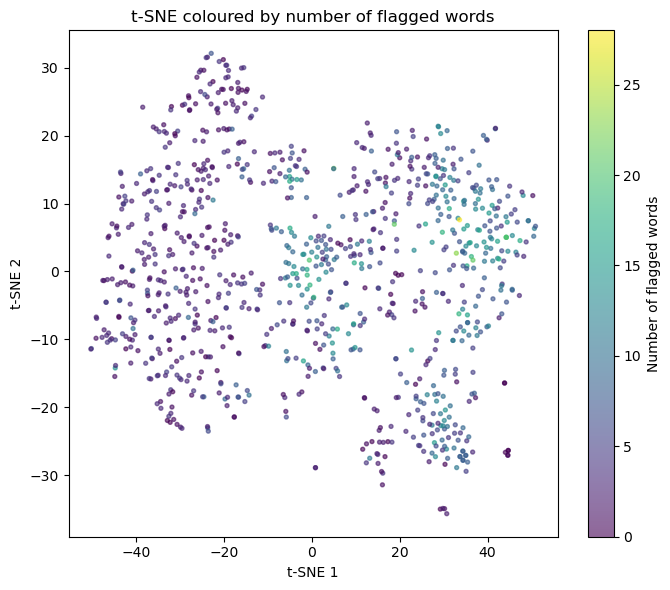

In [39]:
plt.figure(figsize=(7, 6))

scatter = plt.scatter(
    df_plot['tsne_x'],
    df_plot['tsne_y'],
    c=df_plot['num_flagged_words'],
    cmap='viridis',
    s=8,
    alpha=0.6
)

plt.title('t-SNE coloured by number of flagged words')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

cbar = plt.colorbar(scatter)
cbar.set_label('Number of flagged words')

plt.tight_layout()
plt.show()

## Modeling

In [41]:
df_all_common['status'].value_counts()

status
🔄 Possibly Reinstated          3187
❌ Terminated                   3051
🚰 Unfrozen Funding             1109
💧 Possibly Unfrozen Funding     952
🧊 Frozen Funding                157
✅ Reinstated                     47
Name: count, dtype: int64

In [62]:
adverse_statuses = ['❌ Terminated', '🧊 Frozen Funding']

df_all_common['target_adverse'] = df_all_common['status'].isin(adverse_statuses).astype(int)
df_nih['target_adverse'] = df_nih['status'].isin(adverse_statuses).astype(int)


In [43]:
df_all_common["target_adverse"].value_counts()
df_all_common["target_adverse"].value_counts(normalize=True)

target_adverse
0    0.622721
1    0.377279
Name: proportion, dtype: float64

In [44]:
df_all_common.groupby("target_adverse")[["num_flagged_words", "num_pen_words", "num_nyt_words"]].mean()

,num_flagged_words,num_pen_words,num_nyt_words
target_adverse,,,
0,3.980548,2.784891,2.017564
1,7.040212,6.329489,4.526808


Only for NIH

In [45]:
dept_mapping = {
    # Clinical medicine
    'INTERNAL MEDICINE/MEDICINE': 'clinical_medicine',
    'SURGERY': 'clinical_medicine',
    'PEDIATRICS': 'clinical_medicine',
    'OBSTETRICS & GYNECOLOGY': 'clinical_medicine',
    'ANESTHESIOLOGY': 'clinical_medicine',
    'OPHTHALMOLOGY': 'clinical_medicine',
    'DERMATOLOGY': 'clinical_medicine',
    'UROLOGY': 'clinical_medicine',
    'ORTHOPEDICS': 'clinical_medicine',
    'EMERGENCY MEDICINE': 'clinical_medicine',
    'FAMILY MEDICINE': 'clinical_medicine',
    'PHYSICAL MEDICINE & REHAB': 'clinical_medicine',
    'OTOLARYNGOLOGY': 'clinical_medicine',
    'NEUROSURGERY': 'clinical_medicine',
    'DENTISTRY': 'clinical_medicine',

    # Public health
    'PUBLIC HEALTH & PREV MEDICINE': 'public_health',
    'NUTRITION': 'public_health',

    # Biomedical / life sciences
    'MICROBIOLOGY/IMMUN/VIROLOGY': 'biomedical_science',
    'BIOCHEMISTRY': 'biomedical_science',
    'BIOLOGY': 'biomedical_science',
    'ANATOMY/CELL BIOLOGY': 'biomedical_science',
    'PATHOLOGY': 'biomedical_science',
    'PHYSIOLOGY': 'biomedical_science',
    'GENETICS': 'biomedical_science',
    'PHARMACOLOGY': 'biomedical_science',
    'OTHER BASIC SCIENCES': 'biomedical_science',
    'VETERINARY SCIENCES': 'biomedical_science',
    'ZOOLOGY': 'biomedical_science',

    # Neurosciences
    'NEUROLOGY': 'neurosciences',
    'NEUROSCIENCES': 'neurosciences',

    # Psych / behavioral
    'PSYCHIATRY': 'psych_behavioral',
    'PSYCHOLOGY': 'psych_behavioral',

    # Engineering / physical sciences
    'ENGINEERING (ALL TYPES)': 'engineering_physical',
    'BIOMEDICAL ENGINEERING': 'engineering_physical',
    'PHYSICS': 'engineering_physical',
    'RADIATION-DIAGNOSTIC/ONCOLOGY': 'engineering_physical',

    # Social sciences
    'SOCIAL SCIENCES': 'social_sciences',
    'BIOSTATISTICS & OTHER MATH SCI': 'social_sciences',

    # Administrative / other
    'ADMINISTRATION': 'other',
    'OTHER HEALTH PROFESSIONS': 'other',
    'MISCELLANEOUS': 'other',
    'OTHER CLINICAL SCIENCES': 'other',
    'NONE': 'other',
}

In [59]:
df_nih["dept_group"] = (df_nih["dept_type"].map(dept_mapping).fillna("other"))

In [60]:
dept_group_dummies = pd.get_dummies( df_nih["dept_group"], prefix="dept", drop_first=True)

Baseline

In [63]:
df_nih['log_total_award'] = np.log1p(df_nih['total_award'])
feature_columns = ['has_flagged_word', 'num_flagged_words', 'num_pen_words', 'num_nyt_words', 'log_total_award']

X = df_nih[feature_columns].fillna(0)
y = df_nih['target_adverse']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

baseline = LogisticRegression(max_iter=1000, class_weight='balanced')

baseline.fit(X_train, y_train)

y_prob = baseline.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print('ROC AUC:', roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

risk_factors = pd.DataFrame({'feature': X.columns, 'coefficient': baseline.coef_[0]}).sort_values('coefficient', ascending=False)
risk_factors


ROC AUC: 0.6405318699873365
              precision    recall  f1-score   support

           0       0.85      0.68      0.75      1150
           1       0.32      0.56      0.40       309

    accuracy                           0.65      1459
   macro avg       0.58      0.62      0.58      1459
weighted avg       0.74      0.65      0.68      1459



/opt/anaconda3/envs/env12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,feature,coefficient
1,num_flagged_words,0.121205
3,num_nyt_words,0.042469
2,num_pen_words,-0.080733
0,has_flagged_word,-0.232751
4,log_total_award,-0.325099


with dept dummies

In [64]:
X = pd.concat([df_nih[['has_flagged_word', 'num_flagged_words', 'num_pen_words', 'num_nyt_words', 'log_total_award']].fillna(0), dept_group_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

baseline_wd = LogisticRegression(max_iter=1000, class_weight='balanced')

baseline_wd.fit(X_train, y_train)

y_prob = baseline_wd.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print('ROC AUC:', roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

risk_factors = pd.DataFrame({'feature': X.columns, 'coefficient': baseline_wd.coef_[0]}).sort_values('coefficient', ascending=False)
risk_factors


ROC AUC: 0.662724074855776
              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1150
           1       0.32      0.55      0.40       309

    accuracy                           0.66      1459
   macro avg       0.58      0.62      0.58      1459
weighted avg       0.74      0.66      0.68      1459



,feature,coefficient
8,dept_other,0.363188
9,dept_psych_behavioral,0.152822
1,num_flagged_words,0.104054
3,num_nyt_words,0.044857
2,num_pen_words,-0.064163
6,dept_engineering_physical,-0.143239
0,has_flagged_word,-0.180121
5,dept_clinical_medicine,-0.269160
4,log_total_award,-0.310990
11,dept_social_sciences,-0.315759


with embeddings

In [70]:
X_tab = pd.concat([df_nih[['has_flagged_word', 'num_flagged_words', 'num_pen_words', 'num_nyt_words', 'log_total_award']].fillna(0), dept_group_dummies], axis=1)

X_embed = np.vstack(df_nih['embeddings_allminilm'].tolist())

X_hybrid = np.hstack([X_tab, X_embed])

X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y, test_size=0.25, random_state=42, stratify=y)

baseline_em = LogisticRegression(max_iter=3000, class_weight='balanced')

baseline_em.fit(X_train, y_train)

y_prob = baseline_em.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print('ROC AUC:', roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

tabular_feature_names = list(X_tab.columns)
num_embed_dims = X_embed.shape[1]
embedding_feature_names = [f'emb_{i}' for i in range(num_embed_dims)]

all_feature_names = tabular_feature_names + embedding_feature_names

coef_df = (
    pd.DataFrame({'feature': all_feature_names, 'coefficient': baseline_em.coef_[0]})
    .sort_values('coefficient', ascending=False)
)

coef_df.head(20)


ROC AUC: 0.7099479386520332
              precision    recall  f1-score   support

           0       0.88      0.71      0.78      1150
           1       0.36      0.63      0.46       309

    accuracy                           0.69      1459
   macro avg       0.62      0.67      0.62      1459
weighted avg       0.77      0.69      0.71      1459



,feature,coefficient
79,emb_67,1.855864
201,emb_189,1.662114
252,emb_240,1.593480
332,emb_320,1.422609
242,emb_230,1.409386
147,emb_135,1.377746
87,emb_75,1.366210
255,emb_243,1.314780
202,emb_190,1.245994
347,emb_335,1.229052


RF

In [71]:
from sklearn.ensemble import RandomForestClassifier

X_tabular = pd.concat(
    [
        df_nih[["has_flagged_word", "num_flagged_words", "num_pen_words", "num_nyt_words", "log_total_award"]].fillna(0),
        dept_group_dummies
    ],
    axis=1
)

y = df_nih["target_adverse"]

X_embed = np.vstack(df_nih["embeddings_allminilm"].tolist())

X_hybrid = np.hstack([X_tabular.values, X_embed])

X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_tabular, y, test_size=0.25, random_state=42, stratify=y
)

X_hyb_train, X_hyb_test, _, _ = train_test_split(
    X_hybrid, y, test_size=0.25, random_state=42, stratify=y
)

In [72]:
rf_tab = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf_tab.fit(X_tab_train, y_train)

y_prob = rf_tab.predict_proba(X_tab_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("RF (tabular) ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

RF (tabular) ROC AUC: 0.6608878570423526
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1150
           1       0.36      0.44      0.39       309

    accuracy                           0.72      1459
   macro avg       0.60      0.61      0.60      1459
weighted avg       0.74      0.72      0.73      1459



In [ ]:
rf_hybrid = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf_hybrid.fit(X_hyb_train, y_train)

y_prob_h = rf_hybrid.predict_proba(X_hyb_test)[:, 1]
y_pred_h = (y_prob_h >= 0.5).astype(int)

print("RF (hybrid) ROC AUC:", roc_auc_score(y_test, y_prob_h))
print(classification_report(y_test, y_pred_h))

RF (hybrid) ROC AUC: 0.7189615871675813
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1150
           1       0.58      0.16      0.25       309

    accuracy                           0.80      1459
   macro avg       0.70      0.56      0.57      1459
weighted avg       0.76      0.80      0.75      1459



xgboost

In [74]:
from xgboost import XGBClassifier


In [ ]:
# X_tabular = df_nih[["has_flagged_word", "num_flagged_words", "num_pen_words", "num_nyt_words", "log_total_award"]].fillna(0),
#         dept_group_dummies
#     ],
#     axis=1
# )

X_tabular = df_nih[["has_flagged_word", "num_flagged_words", "num_pen_words", "num_nyt_words", "log_total_award"]].fillna(0)


X_embed = np.vstack(df_nih["embeddings_allminilm"].tolist())

X_hybrid = np.hstack([X_tabular.values, X_embed])

train_idx, test_idx = train_test_split(
    df_nih.index,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_tab_train = X_tabular.loc[train_idx]
X_tab_test  = X_tabular.loc[test_idx]
X_hyb_train = X_hybrid[np.isin(df_nih.index, train_idx)]
X_hyb_test  = X_hybrid[np.isin(df_nih.index, test_idx)]

y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [ ]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos

xgb_tab = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=5,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
)

xgb_tab.fit(X_tab_train, y_train)

y_prob = xgb_tab.predict_proba(X_tab_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("XGBoost (tabular) ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

XGBoost (tabular) ROC AUC: 0.6258153932742367
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1150
           1       0.30      0.45      0.36       309

    accuracy                           0.66      1459
   macro avg       0.57      0.59      0.57      1459
weighted avg       0.72      0.66      0.68      1459



In [ ]:
xgb_hybrid = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=3,      
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,  
    min_child_weight=10,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
)

xgb_hybrid.fit(X_hyb_train, y_train)

y_prob_h = xgb_hybrid.predict_proba(X_hyb_test)[:, 1]
y_pred_h = (y_prob_h >= 0.5).astype(int)

print("XGBoost (hybrid) ROC AUC:", roc_auc_score(y_test, y_prob_h))
print(classification_report(y_test, y_pred_h))

XGBoost (hybrid) ROC AUC: 0.4955339805825242
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1150
           1       0.26      0.16      0.19       309

    accuracy                           0.73      1459
   macro avg       0.53      0.52      0.52      1459
weighted avg       0.68      0.73      0.70      1459



In [82]:
importances = pd.DataFrame({
    "feature": X_tabular.columns,
    "importance": xgb_tab.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(25)

,feature,importance
4,log_total_award,0.287910
1,num_flagged_words,0.239906
2,num_pen_words,0.189761
3,num_nyt_words,0.167097
0,has_flagged_word,0.115326


linear svm

In [83]:
from sklearn.svm import SVC

svm = SVC(
    kernel="linear",
    probability=True,
    class_weight="balanced",
    C=0.5,
    random_state=42,
)

svm.fit(X_train, y_train)

,C,0.5
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False
